# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [2]:
# Add any additional import statements you need here
import nltk
from nltk.tokenize import word_tokenize
# nltk.download('punkt')

from pathlib import Path
import glob
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "data/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [4]:
# Read in the lyrics data
# Read in the lyrics data
lyrics_path = data_location + lyrics_folder
PATH = glob.iglob(f'{lyrics_path}/*')

""" 
    Example format:
    {
        'artist': cher,
        'filename': "cher_88degrees.txt",
        'title': "88 Degrees",
        'lyrics': "Stuck in L.A., ain't got no friends ..."
    }
"""

lyrics_list = []

for subdir in PATH:

    # Define subdirectories
    path = Path(subdir).glob('*')

#     # Iterate over song txt files
    for file in path:

        # Obtain file names, artists, song titles, and lyrics 
        filename = Path(file).name
        artist = filename.split("_")[0]
        title = open(file, 'r').readline().strip("\n")
        lyrics = ' '.join([line.strip() for line in open(file, 'r').readlines()[3:]]).lstrip()

        # Key-values
        lyrics_dict = {
            'artist': artist,
            'filename': filename,
            'title': title,
            'lyrics': lyrics
            }
        lyrics_list.append(lyrics_dict)

lyrics_df = pd.DataFrame(lyrics_list)
lyrics_df.head()

,artist,filename,title,lyrics
0,cher,cher_88degrees.txt,"""88 Degrees""","Stuck in L.A., ain't got no friends And so Hol..."
1,cher,cher_adifferentkindoflovesong.txt,"""A Different Kind Of Love Song""",What if the world was crazy and I was sane Wou...
2,cher,cher_afterall.txt,"""After All""","Well, here we are again I guess it must be fat..."
3,cher,cher_again.txt,"""Again""",Again evening finds me at your door Here to as...
4,cher,cher_alfie.txt,"""Alfie""","What's it all about, Alfie? Is it just for the..."


In [5]:
# Read in the twitter data
cher_twitter_df = pd.read_csv('data/twitter/cher_followers_data.txt', sep='\t', on_bad_lines='warn')

Skipping line 624: expected 7 fields, saw 12
Skipping line 17506: expected 7 fields, saw 12
Skipping line 104621: expected 7 fields, saw 12

Skipping line 188924: expected 7 fields, saw 12

Skipping line 301600: expected 7 fields, saw 12

Skipping line 429936: expected 7 fields, saw 12
Skipping line 444405: expected 7 fields, saw 12

Skipping line 677792: expected 7 fields, saw 12
Skipping line 773482: expected 7 fields, saw 12

Skipping line 818258: expected 7 fields, saw 12
Skipping line 895225: expected 7 fields, saw 12

Skipping line 955213: expected 7 fields, saw 10
Skipping line 994827: expected 7 fields, saw 12

Skipping line 1246039: expected 7 fields, saw 12

Skipping line 1569117: expected 7 fields, saw 12

Skipping line 2127250: expected 7 fields, saw 12

Skipping line 2335031: expected 7 fields, saw 12

Skipping line 2681065: expected 7 fields, saw 10

Skipping line 3147696: expected 7 fields, saw 12



In [6]:
cher_twitter_df.head()

,screen_name,name,id,location,followers_count,friends_count,description
0,hsmcnp,Country Girl,3.515221e+07,NaN,1302.0,1014.0,NaN
1,horrormomy,Jeny,7.421531e+17,Earth,81.0,514.0,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜
2,anju79990584,anju,1.496463e+18,NaN,13.0,140.0,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡
3,gallionjenna,J,3.366480e+09,NaN,752.0,556.0,csu
4,bcscomm,bcscomm,8.391504e+07,"Washington, DC",888.0,2891.0,Writer @Washinformer @SpelmanCollege alumna #D...


In [7]:
robyn_twitter_df = pd.read_csv('data/twitter/robynkonichiwa_followers_data.txt', sep='\t', on_bad_lines='warn')

In [8]:
# Combine twitter dataframes
cher_twitter_df['artist'] = 'cher'
robyn_twitter_df['artist'] = 'robyn'

twitter_df = pd.concat([cher_twitter_df, robyn_twitter_df])
# Dropping unneccessary columns for emoji analysis
twitter_df = twitter_df.drop(columns=['id', 'location', 'followers_count', 'friends_count'])
# Dropping NaN due to float() error in final section
twitter_df = twitter_df.dropna()

print(len(twitter_df))
twitter_df.head()

2148511


,screen_name,name,description,artist
1,horrormomy,Jeny,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher
2,anju79990584,anju,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher
3,gallionjenna,J,csu,cher
4,bcscomm,bcscomm,Writer @Washinformer @SpelmanCollege alumna #D...,cher
6,Rodhandyjj,Art Vandalay 🇺🇦🇺🇦🇺🇦,I’m unemployed and live with my parents. MOOPS!,cher


In [9]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

sent_df = pd.read_csv('tidytext_sentiments.txt', sep='\t')
# Score sentiment
def score_sentiment(row):
    if row['sentiment'] == 'negative':
        return -1
    if row['sentiment'] == 'positive':
        return 1
sent_df['score'] = sent_df.apply(score_sentiment, axis=1)

sent_df.sample(10)

,word,sentiment,lexicon,score
1194,cultivate,positive,nrc,1
4190,reimburse,positive,nrc,1
12147,valiant,positive,bing,1
7496,dropouts,negative,bing,-1
3794,piety,positive,nrc,1
10643,renown,positive,bing,1
1273,declaratory,positive,nrc,1
2309,grasping,negative,nrc,-1
13039,devolved,negative,loughran,-1
3477,nigger,negative,nrc,-1


In [10]:
# Read positive words
pos_words = pd.read_csv('positive-words.txt', sep='\t', names=['word'], skiprows=35)
pos_words['sentiment'] = 'positive'
pos_words['score'] = pos_words.apply(score_sentiment, axis=1)

# Read negatie words
neg_words = pd.read_csv('negative-words.txt', sep='\t', names=['word'], skiprows=35)
neg_words['sentiment'] = 'negative'
neg_words['score'] = neg_words.apply(score_sentiment, axis=1)

print('Positive Word Lexicon')
print(pos_words.sample(5))
print(' ')
print('nununununununununun')
print(' ')
print('Negative Word Lexicon')
print(neg_words.sample(5))

Positive Word Lexicon
              word sentiment  score
892        headway  positive      1
1344      prettily  positive      1
854   gratifyingly  positive      1
427      desirable  positive      1
1253        pamper  positive      1
 
nununununununununun
 
Negative Word Lexicon
          word sentiment  score
1251  disprove  negative     -1
0      2-faced  negative     -1
1767   fretful  negative     -1
2683  leakages  negative     -1
265     barren  negative     -1


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [11]:
# your code here
# The following code is from the Bing Liu Lexicon section of 
# Chapter 11: Performing Sentiment Analysis on Text Data (p. 303).
pos_score = 1
neg_score = -1
word_dict = sent_df.set_index('word').to_dict()['score']

def bing_liu_score(text: str) -> int:
    sentiment_score = 0
    bag_of_words = word_tokenize(text.lower()) 
    
    for word in bag_of_words:
        if word in word_dict:
            sentiment_score += word_dict[word]
    
    return (sentiment_score/len(bag_of_words))

In [12]:
lyrics_df['sentiment_score'] = lyrics_df['lyrics'].apply(bing_liu_score)
lyrics_df.head()

,artist,filename,title,lyrics,sentiment_score
0,cher,cher_88degrees.txt,"""88 Degrees""","Stuck in L.A., ain't got no friends And so Hol...",0.028011
1,cher,cher_adifferentkindoflovesong.txt,"""A Different Kind Of Love Song""",What if the world was crazy and I was sane Wou...,0.132616
2,cher,cher_afterall.txt,"""After All""","Well, here we are again I guess it must be fat...",-0.016181
3,cher,cher_again.txt,"""Again""",Again evening finds me at your door Here to as...,-0.012048
4,cher,cher_alfie.txt,"""Alfie""","What's it all about, Alfie? Is it just for the...",0.065089


### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: Though Robyn has the highest overall score, Cher has a higher average sentiment per song.

---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: Top and bottom 3 listed below. The highest sentiment discussed love, while the lowest sentiment use words such as 'bang' and 'don't' frequently.

---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: Top and bottom 3 listed below.  The highest sentiment discussed love and forgiveness, while the lowest sentiment use words such as 'killing'.

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.




In [13]:
# Cher top-5
lyrics_df[lyrics_df['artist'] == 'cher'].sort_values(by=['sentiment_score'], ascending=False).head()

,artist,filename,title,lyrics,sentiment_score
155,cher,cher_loveandunderstanding.txt,"""Love And Understanding""","Here, here in this world Where do we go? Where...",0.188312
108,cher,cher_ifoundyoulove.txt,"""I Found You Love""","Well I was looking for a new love, a different...",0.181518
140,cher,cher_justenoughtokeepmehanginon.txt,"""(Just Enough To Keep Me) Hangin' On""","It's true, you got me wrapped around your fing...",0.141463
62,cher,cher_dreambaby.txt,"""Dream Baby""",I found the boy for me He's my dream baby He ...,0.141361
114,cher,cher_iknowyoudontloveme.txt,"""I Know (You Don't Love Me)""",Uh uh uh You don't love me Yes I know Uh-uh-uh...,0.139241


In [14]:
# Print lyrics of top-3 songs
print(lyrics_df['title'][155])
print(lyrics_df['lyrics'][155])
print('\n')
print(lyrics_df['title'][108])
print(lyrics_df['lyrics'][108])
print('\n')
print(lyrics_df['title'][140])
print(lyrics_df['lyrics'][140])
print('\n')

"Love And Understanding"
Here, here in this world Where do we go? Where can we turn? When we need some love It seems that love just can't be found Where, where do we stand? When love's supply don't meet love's demand  We got enough stars to light the sky at night Enough sun to make to make the whole world bright We got more than enough But there's one thing there's just not enough of  Not enough love and understanding We could use some love to ease these troubled times Not enough love and understanding Why, oh why?  Spend all of our time Building buildings up to the sky Reaching everywhere But where we need to reach the most Hearts never can win Oh, in this race, this race that we're in  We've got enough cars to drive around the world Enough planes to take us anywhere We got more than enough But there's one thing there's just not enough of  Not enough love and understanding We could use some love to ease these troubled times Not enough love and understanding Why, oh why?  Not enough lo

In [15]:
# Cher bottom-3
lyrics_df[lyrics_df['artist'] == 'cher'].sort_values(by=['sentiment_score'], ascending=False).tail(3)

,artist,filename,title,lyrics,sentiment_score
80,cher,cher_girldontcome.txt,"""Girl Don't Come""",You have a date for half past eight tonight So...,-0.110132
17,cher,cher_bangbangmybabyshotmedown.txt,"""Bang Bang (My Baby Shot Me Down)""",I was five and he was six We rode on horses ma...,-0.182320
16,cher,cher_bangbang.txt,"""Bang-Bang""",Bang bang you shot me down Bang bang I hit the...,-0.245614


In [16]:
# Print lyrics of bottom-3 songs
print(lyrics_df['title'][80])
print(lyrics_df['lyrics'][80])
print('\n')
print(lyrics_df['title'][17])
print(lyrics_df['lyrics'][17])
print('\n')
print(lyrics_df['title'][16])
print(lyrics_df['lyrics'][16])
print('\n')

"Girl Don't Come"
You have a date for half past eight tonight Some distant bell starts chiming nine You wanna see her, oh, you wanna see her, oh yeah But you wait, you wait and wait Girl don't come  The time rolls on, those minutes fly by You wanna go, but just you try, guy You wanna see her, oh, you wanna see her, oh yeah But you wait, you wait and wait Girl don't come  You've been stood up, tears fill your eyes, whoa You hurt inside, you wanna die  You had a date for half past eight tonight Some distant bell starts chiming nine You wanna see her, you wanna see her, oh yeah So you wait, you wait and wait Girl don't come  You've been stood up, tears fill your eyes, whoa You hurt inside, you wanna die You wanna see her, oh, you wanna see her, oh yeah But you wait, you wait and wait Girl don't come  Girl don't come, girl don't come Girl don't come, girl don't come Girl don't come, girl don't come


"Bang Bang (My Baby Shot Me Down)"
I was five and he was six We rode on horses made of sti

In [17]:
# Robyn top-5
lyrics_df[lyrics_df['artist'] == 'robyn'].sort_values(by=['sentiment_score'], ascending=False).head()

,artist,filename,title,lyrics,sentiment_score
161,robyn,robyn_babyforgiveme.txt,"""Baby Forgive Me""","Here come the night In your eyes Baby, be brav...",0.240741
165,robyn,robyn_betweenthelines.txt,"""Between The Lines""","Even reading in between the lines Every day, ...",0.113122
167,robyn,robyn_bionicwoman.txt,"""Bionic Woman""",Good evening ladies This is your captain speak...,0.105263
189,robyn,robyn_doyoureallywantmeshowrespect.txt,"""Do You Really Want Me (Show Respect)""",Boy listen to me careful now Cause this is som...,0.103448
158,robyn,robyn_88days.txt,"""88 Days""",I light a candle in the morning To signify tha...,0.082090


In [18]:
# Robyn bottom-3
lyrics_df[lyrics_df['artist'] == 'robyn'].sort_values(by=['sentiment_score'], ascending=False).tail(3)

,artist,filename,title,lyrics,sentiment_score
176,robyn,robyn_criminalintent.txt,"""Criminal Intent""","Somebody alert the authorities, I got criminal...",-0.100000
185,robyn,robyn_dontfuckingtellmewhattodo114520.txt,"""Don't Fucking Tell Me What To Do""",My drinking is killing me My drinking is killi...,-0.196833
184,robyn,robyn_dontfuckingtellmewhattodo.txt,"""Don't Fucking Tell Me What To Do""",My drinking is killing me My drinking is killi...,-0.196833


In [19]:
# Print lyrics of top-3 Robyn songs
print(lyrics_df['title'][161])
print(lyrics_df['lyrics'][161])
print('\n')
print(lyrics_df['title'][165])
print(lyrics_df['lyrics'][165])
print('\n')
print(lyrics_df['title'][167])
print(lyrics_df['lyrics'][167])
print('\n')

"Baby Forgive Me"
Here come the night In your eyes Baby, be brave Be wise It's up to you You do what you like, mmm Won't you give it a chance, baby? Just one more try  Baby forgive me Baby forgive me Baby forgive me Baby forgive me  (Won't you give it a chance, baby?) Won't you give it a chance, baby? Just one more try One more try Yeah, eh  You got the power You set the price But baby, be fair Be nice You say you want to be happy Then you got to put your love on the line Just let me make you smile again, baby I know we can work it out Yes, I know we can  Baby forgive me Yeah Baby forgive me Baby forgive me Baby forgive me Baby forgive me Baby forgive me Baby forgive me Baby forgive me


"Between The Lines"
Even reading in between the lines  Every day, you hit my phone up Every time (You hit my phone up) It makes my heart jump I want you to say it, baby (It makes my heart jump) Say it like you mean it It's right there on the tip of your tongue (You hit my phone up) And I can feel it An

In [20]:
# Print lyrics of bottom-3 Robyn songs
print(lyrics_df['title'][176])
print(lyrics_df['lyrics'][176])
print('\n')
print(lyrics_df['title'][185])
print(lyrics_df['lyrics'][185])
print('\n')
print(lyrics_df['title'][184])
print(lyrics_df['lyrics'][184])
print('\n')

"Criminal Intent"
Somebody alert the authorities, I got criminal intent Conspiracy to engage in lewd and indecent acts and events I'mma wind it, grind it, oh my, I'mma say it again Somebody alert the authorities, she's got criminal intent  Somebody alert the authorities, I got criminal intent Conspiracy to engage in lewd and indecent acts and events I'mma wind it, grind it, oh my, I'mma say it again Somebody alert the authorities, she's got criminal intent  Somebody alert the authorities, I got criminal intent Conspiracy to engage in lewd and indecent acts and events I'mma wind it, grind it, oh my, I'mma say it again Somebody alert the authorities, I got criminal intent  - Will the defendant please rise? State your full name for the record. - Robyn - Do you wish to say anything before the sentence is imposed? - I do your Honor!  You know, from time to time I need to get down Unwind and just bump and grind Get my shot on, have some fun A little dirty never hurt anyone I admit, I can get

c:\Users\Bryan\anaconda3\envs\ads_venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Density')

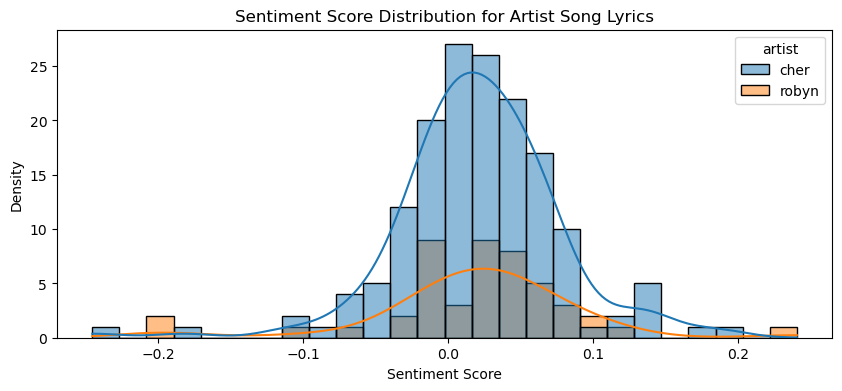

In [21]:
plt.figure(figsize=(10, 4))
sns.histplot(data=lyrics_df, x='sentiment_score', hue='artist', kde=True)

plt.title('Sentiment Score Distribution for Artist Song Lyrics')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [ ]:
# your code here
# Emoji dictionary received from ADS colleague S. Reagin
emoji_dict = {
    #positive emojis
    '😂': 1,    '❤️': 1,    '😭': 1,    '😍': 1,    '♥️': 1,    '😊': 1,
    '💕': 1,    '😘': 1,    '😁': 1,    '🔥': 1,    '🙏': 1,    '☺️': 1,
    '👍': 1,    '😉': 1,    '👌': 1,    '😏': 1,    '✨': 1,    '😌': 1,
    '😎': 1,    '💜': 1,    '💙': 1,    '💯': 1,    '💖': 1,    '🎶': 1,
    '🙌': 1,    '😋': 1,    '🙈': 1,    '😄': 1,    '✌️': 1,    '💛': 1,
    '😜': 1,    '💪': 1,    '😀': 1,    '💞': 1,    '💚': 1,    '🎉': 1,
    '😆': 1,    '😃': 1,    '💋': 1,    '💘': 1,    '😇': 1,    '😝': 1,
    '😚': 1,    '😛': 1,

    #negative emojis
    '😶': -1,    '😠': -1,    '😖': -1,    '😔': -1,    '😒': -1,    '😩': -1,
    '😅': -1,    '💔': -1,    '😢': -1,    '😳': -1,    '😞': -1,    '😑': -1,
    '😐': -1,    '😪': -1,    '😕': -1,    '😱': -1,    '😬': -1,    '😫': -1,
    '😤': -1,    '😣': -1,    '😓': -1,    '😥': -1,    '😡': -1

}

#another dictionary but same count of positive and negative emojis
emoji_dict2 = { 
    #positive emojis
    '😂': 1,     '❤️': 1,     '😭': 1,     '😍': 1,     '♥️': 1,     '😊': 1,
    '💕': 1,     '😘': 1,     '😁': 1,     '🔥': 1,     '🙏': 1,     '☺️': 1,
    '👍': 1,     '😉': 1,     '👌': 1,     '😏': 1,     '✨': 1,     '😌': 1,
    '😎': 1,     '💜': 1,     '💯': 1,     '💖': 1,     '🎶': 1,

    #negative emojis
    '😶': -1,    '😠': -1,    '😖': -1,    '😔': -1,    '😒': -1,    '😩': -1,
    '😅': -1,    '💔': -1,    '😢': -1,    '😳': -1,    '😞': -1,    '😑': -1,
    '😐': -1,    '😪': -1,    '😕': -1,    '😱': -1,    '😬': -1,    '😫': -1,
    '😤': -1,    '😣': -1,    '😓': -1,    '😥': -1,    '😡': -1

}

In [ ]:
# Create emoji columns for twitter data
# NOTE: only run if necessary! runtime approximately 3 mins. read in csv instead.
twitter_df['emoji'] = twitter_df['description'].map(emoji.distinct_emoji_list)


In [22]:
# Score emojis
def count_emojis(text: str, emo_dict: dict) -> int:
    return sum(emo_dict.get(emoji, 0) for emoji in text)

# When using the above function in .apply(count_emojis, args=(emoji_dict, )) 
# it produces the following error:
# TypeError: count_emojis() takes 1 positional argument but 2 were given
# I was unable to correct it in a timely manner.
# HACK: Creating 2 separate functions for each dictionary as a workaround

def count_emojis_v1(text: str) -> int:
    return sum(emoji_dict.get(emoji, 0) for emoji in text)

def count_emojis_v2(text: str) -> int:
    return sum(emoji_dict2.get(emoji, 0) for emoji in text)


In [ ]:
# Create score columns
# NOTE: Scores in csv. Don't run unless necessary
twitter_df['emoji_score_1'] = twitter_df['emoji'].apply(count_emojis_v1)
twitter_df['emoji_score_2'] = twitter_df['emoji'].apply(count_emojis_v2)

In [ ]:
# Store as csv
# twitter_df.to_csv('data/twitter_scores.csv')

In [23]:
# Read twitter_score csv
twitter_df = pd.read_csv('data/twitter_scores.csv')
twitter_df.head(10)

,Unnamed: 0,screen_name,name,description,artist,emoji,emoji_score_1,emoji_score_2
0,1,horrormomy,Jeny,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher,[],0,0
1,2,anju79990584,anju,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher,"['🍒', '💜', '💓', '🧡']",1,1
2,3,gallionjenna,J,csu,cher,[],0,0
3,4,bcscomm,bcscomm,Writer @Washinformer @SpelmanCollege alumna #D...,cher,[],0,0
4,6,Rodhandyjj,Art Vandalay 🇺🇦🇺🇦🇺🇦,I’m unemployed and live with my parents. MOOPS!,cher,[],0,0
5,7,JackBianchi7,Jackson,zoowee mama,cher,[],0,0
6,9,macryant900,SpyderRyder,Let the healing begin. Let us learn from the p...,cher,['🇨🇦'],0,0
7,10,notdevilanse,Amanda 😇,do what thou wilt. 🖤✨,cher,"['✨', '🖤']",1,1
8,12,bloomingrx,Roxana M 🇺🇦🇨🇦,Curious Canadian Contemplator. She/Her. Sexage...,cher,[],0,0
9,17,Taliaasaurus,Σκουπίδια,(She/Her/Hers) Feminist. LGBTQ+. BLM. Mental h...,cher,[],0,0


Q: What is the average sentiment of your two artists? 

A: <!-- Your answer here --> 

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: <!-- Your answer here --> 



In [24]:
print('Average score per artist for Emoji Dictionary 1')
mean_emoji_score_1 = twitter_df.groupby('artist')['emoji_score_1'].mean()
print(f'{mean_emoji_score_1}')

print('\n')

print('Average score per artist for Emoji Dictionary 2')
mean_emoji_score_2 = twitter_df.groupby('artist')['emoji_score_2'].mean()
print(f'{mean_emoji_score_2}')

Average score per artist for Emoji Dictionary 1
artist
cher     0.099477
robyn    0.055603
Name: emoji_score_1, dtype: float64


Average score per artist for Emoji Dictionary 2
artist
cher     0.068775
robyn    0.039918
Name: emoji_score_2, dtype: float64


In [25]:
positive_emojis = {
    #positive emojis
    '😂': 1,    '❤️': 1,    '😭': 1,    '😍': 1,    '♥️': 1,    '😊': 1,
    '💕': 1,    '😘': 1,    '😁': 1,    '🔥': 1,    '🙏': 1,    '☺️': 1,
    '👍': 1,    '😉': 1,    '👌': 1,    '😏': 1,    '✨': 1,    '😌': 1,
    '😎': 1,    '💜': 1,    '💙': 1,    '💯': 1,    '💖': 1,    '🎶': 1,
    '🙌': 1,    '😋': 1,    '🙈': 1,    '😄': 1,    '✌️': 1,    '💛': 1,
    '😜': 1,    '💪': 1,    '😀': 1,    '💞': 1,    '💚': 1,    '🎉': 1,
    '😆': 1,    '😃': 1,    '💋': 1,    '💘': 1,    '😇': 1,    '😝': 1,
    '😚': 1,    '😛': 1
}

negative_emojis = {
    #negative emojis
    '😶': -1,    '😠': -1,    '😖': -1,    '😔': -1,    '😒': -1,    '😩': -1,
    '😅': -1,    '💔': -1,    '😢': -1,    '😳': -1,    '😞': -1,    '😑': -1,
    '😐': -1,    '😪': -1,    '😕': -1,    '😱': -1,    '😬': -1,    '😫': -1,
    '😤': -1,    '😣': -1,    '😓': -1,    '😥': -1,    '😡': -1

}

In [26]:
# Cher most popular positive/negative emojis
cher_emojis = twitter_df.loc[twitter_df['artist']=='cher', ['emoji','emoji_score_1']]
cher_emojis = list(cher_emojis['emoji'])
cher_emojis = [i for sublist in cher_emojis for i in sublist]

cher_pos_emojis = Counter([i for i in cher_emojis if i in positive_emojis]).most_common(5)
cher_neg_emojis = Counter([i for i in cher_emojis if i in negative_emojis]).most_common(5)

print( "Cher's most popular positive emojis :", cher_pos_emojis) 

print('\n')

print( "Cher's most popular negative emojis :", cher_neg_emojis) 

Cher's most popular positive emojis : [('✨', 20365), ('💙', 16390), ('💜', 12816), ('💕', 9077), ('💚', 7325)]


Cher's most popular negative emojis : [('💔', 1322), ('😅', 547), ('😬', 445), ('😔', 355), ('😳', 307)]


In [27]:
# Robyn most popular positive/negative emojis
robyn_emojis = twitter_df.loc[twitter_df['artist']=='robyn', ['emoji','emoji_score_1']]
robyn_emojis = list(robyn_emojis['emoji'])
robyn_emojis = [i for sublist in cher_emojis for i in sublist]

robyn_pos_emojis = Counter([i for i in robyn_emojis if i in positive_emojis]).most_common(5)
robyn_neg_emojis = Counter([i for i in robyn_emojis if i in negative_emojis]).most_common(5)

print( "Cher's most popular positive emojis :", robyn_pos_emojis) 

print('\n')

print( "Cher's most popular negative emojis :", robyn_neg_emojis) 

Cher's most popular positive emojis : [('✨', 20365), ('💙', 16390), ('💜', 12816), ('💕', 9077), ('💚', 7325)]


Cher's most popular negative emojis : [('💔', 1322), ('😅', 547), ('😬', 445), ('😔', 355), ('😳', 307)]
